<p align="center"><h1 align="center">QMSS5074GR <br> Projects in Advanced Machine Learning <br>Spring 2024 <br> FINAL PROJECT <br>Assignment 3 Part 2 [GROUP Assignment]</h1>

---
<br>

#### **Your Unis** : sc4040, ajh2259, fsa2139
#### **Your Full names** : Shayan Chowdhury, Andrew Hamilton, Faaz Saad Arshad
#### **Your AI Model Share Usernames**: sc4040, ajh2259, fsa2139
#### **Link to your Public Github repository** : https://github.com/fsarshad/NLPAdvMLHW3
#### **Team member Contribution Percentages** : 33.33%, 33.33%, 33.33%

## Stanford Sentiment Treebank - Movie Review Classification Competition


## **Instructions: [Total 85 Points for this part]**
1.   Get data in and set up X_train / X_test / y_train
2.   Preprocess data using keras Tokenizer/ Write and Save Preprocessor function
3. Fit model on preprocessed data and save preprocessor function and model
4. Generate predictions from X_test data and submit model to competition
5. Repeat submission process to improve place on leaderboard



## 1. Get data in and set up X_train, X_test, y_train objects

In [1]:
#install aimodelshare library
! pip install -q aimodelshare

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 975.8/975.8 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.3/96.3 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.5/298.5 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.0/329.0 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.4/178.4 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.0/147.0 kB

In [2]:
# Get competition data
from aimodelshare import download_data
download_data('public.ecr.aws/y2e2a1d6/sst2_competition_data-repository:latest')


Data downloaded successfully.


In [6]:
!mv sst2_competition_data data/sst2_competition_data

# 2. Setup
Rerun after every time the runtime crashes (thank you, Colab)

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout, Embedding, GlobalMaxPooling1D, BatchNormalization, Input
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [8]:
# HELPER FUNCTIONS

def plot_history(history, title='Model Performance'):
    # Plot the training history (loss + accuracy)
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    # fig, ax = plt.subplots(1, 2, figsize=(20, 5))

    fig.suptitle(title, fontsize=16)

    # Plot training & validation loss values in the first subplot
    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[0].set_title('Model loss')
    axs[0].set_ylabel('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Val'])

    # Plot training & validation accuracy values in the second subplot
    if 'accuracy' in history.history:
        axs[1].plot(history.history['accuracy'])
        axs[1].plot(history.history['val_accuracy'])
    elif 'acc' in history.history:
        axs[1].plot(history.history['acc'])
        axs[1].plot(history.history['val_acc'])
    axs[1].set_title('Model accuracy')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Val'])

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the combined plot
    plt.show()

from aimodelshare.aimsonnx import model_to_onnx

# Save tf.keras model (or any tensorflow model) to local ONNX file
def save_model_onxx(model, model_filename, framework='keras', transfer_learning=False, deep_learning=False):
    onnx_model = model_to_onnx(
        model,
        framework=framework,
        transfer_learning=transfer_learning,
        deep_learning=deep_learning
    )

    with open(model_filename, "wb") as f:
        f.write(onnx_model.SerializeToString())
        print(f"Model saved to {model_filename}")

# Upload predictions to AI Model Share
def upload_preds_to_aimodelshare(model, model_filename, X_test, columns, competition, preprocessor_filename='preprocessor.zip'):
    # Generate predictions and extract the index of the highest probability
    prediction_column_index = model.predict(X_test).argmax(axis=1)
    # Extract the text labels for the highest probability index
    prediction_labels = [columns[i] for i in prediction_column_index]
    # Submit predictions to competition Leaderboard
    competition.submit_model(
        model=model_filename,
        preprocessor=preprocessor_filename,
        prediction_submission=prediction_labels
    )

# Get leaderboard to explore current best model architectures
def show_leaderboard(competition):
    # Get raw data in pandas data frame
    data = competition.get_leaderboard()
    # Stylize leaderboard data
    return competition.stylize_leaderboard(data)

In [9]:
# Set up X_train, X_test, and y_train_labels objects
X_train = pd.read_csv("./data/sst2_competition_data/X_train.csv", usecols=['text']).squeeze()
X_test = pd.read_csv("./data/sst2_competition_data/X_test.csv", usecols=['text']).squeeze()
y_train_labels = pd.read_csv("./data/sst2_competition_data/y_train_labels.csv",usecols=['label']).squeeze()

# Convert to series if your following preprocessor needs it

# One hot encode encode Y data here
y_train = pd.get_dummies(y_train_labels)

X_train.head()

0    The Rock is destined to be the 21st Century 's...
1    The gorgeously elaborate continuation of `` Th...
2    Singer/composer Bryan Adams contributes a slew...
3                 Yet the act is still charming here .
4    Whether or not you 're enlightened by any of D...
Name: text, dtype: object

## 2.   Preprocess data using keras tokenizer / Write and Save Preprocessor function


In [10]:
MAX_WORDS = 10000 # Maximum number of words to keep in tokenizer
MAX_LENGTH = 100 # Maximum length of text data

# [3 Pts]for this cell
# Build vocabulary from training text data
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(X_train)

# This preprocessor function makes use of the tf.keras tokenizer
# preprocessor tokenizes words and makes sure all documents have the same length (perform padding with maxlen=40)
def preprocessor(data, max_length=MAX_LENGTH):
    # Use tokenizer to convert text data to sequences
    sequences = tokenizer.texts_to_sequences(data)
    # Pad sequences to ensure uniform length
    sequences = pad_sequences(sequences, maxlen=max_length)
    return sequences

print(preprocessor(X_train).shape)
print(preprocessor(X_test).shape)

(6920, 100)
(1821, 100)


In [11]:
# Set up AI Model Share
import aimodelshare as ai
from aimodelshare.aws import set_credentials

# Set up AWS credentials w/ aimodelshare.org username/password
apiurl = "https://rlxjxnoql9.execute-api.us-east-1.amazonaws.com/prod/m" # This is the unique rest api that powers this specific Playground
set_credentials(apiurl=apiurl)

# Instantiate AIModelShare competition
mycompetition = ai.Competition(apiurl)

# Save preprocessor function to local file
ai.export_preprocessor(preprocessor,"")

Modelshare.ai Username:··········
Modelshare.ai Password:··········
Modelshare.ai login credentials set successfully.
Your preprocessor is now saved to 'preprocessor.zip'


# 3. Fit model on preprocessed data and save preprocessor function and model


In [ ]:
# A basic deep learning model (max 5 layers)  # [1 Pts]
model_basic = Sequential([
    Embedding(10000, 16, input_length=MAX_LENGTH),
    Flatten(),
    Dense(2, activation='softmax')
])
model_basic.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 16)           160000    
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dense_11 (Dense)            (None, 2)                 3202      
                                                                 
Total params: 163202 (637.51 KB)
Trainable params: 163202 (637.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Compile model
model_basic.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Set up callbacks
checkpoint = ModelCheckpoint(
    'models/model.h5',
    monitor = 'val_loss',
    verbose = 1,
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    verbose = 1,
    patience = 5,
    min_lr = 0.001
)

# Train model
history_model_basic = model_basic.fit(
    preprocessor(X_train),
    y_train,
    epochs = 10,
    batch_size = 32,
    validation_split=0.2,
    verbose = 1,
    callbacks = [reduce_lr, checkpoint]
)

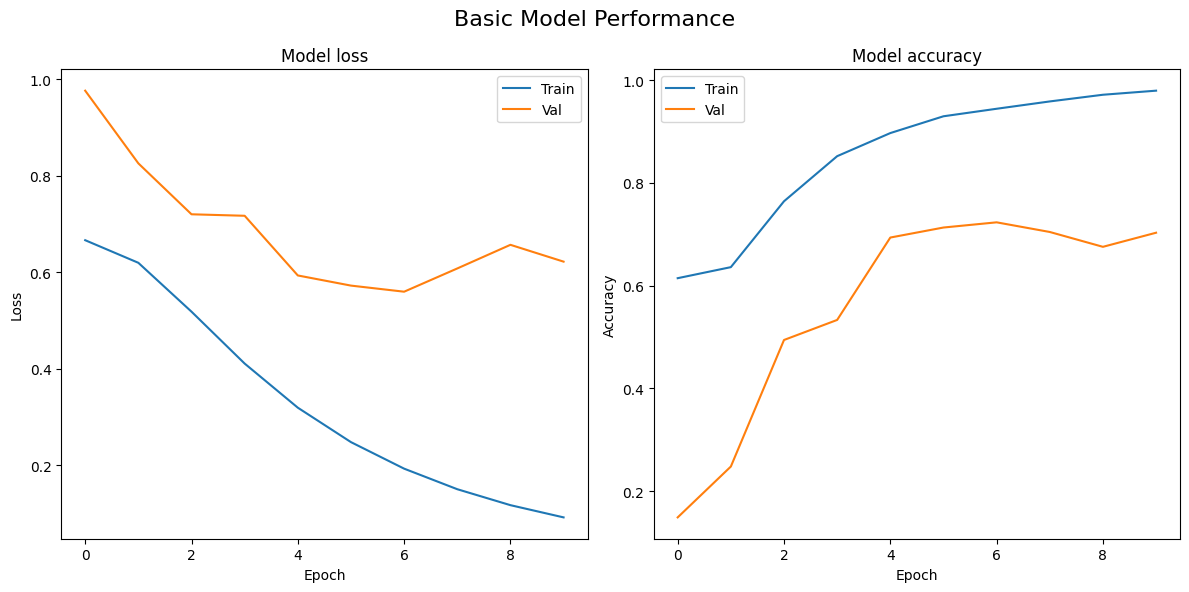

In [ ]:
# Plot history [1 Pts]
plot_history(history_model_basic, title='Basic Model Performance')

In [ ]:
# Save basic model to ONNX file
save_model_onxx(
    model=model_basic,
    model_filename="models/model.onnx",
    deep_learning=True
)

# Generate predictions and submit to competition
upload_preds_to_aimodelshare(
    model=model_basic,
    model_filename="models/model.onnx",
    X_test=preprocessor(X_test),
    columns=y_train.columns,
    competition=mycompetition,
    preprocessor_filename="preprocessor.zip"
)

In [ ]:
# Finally, show the leaderboard
show_leaderboard(mycompetition)

## 5. Repeat submission process to improve place on leaderboard


In [ ]:
# Preprocess text data
X_train_preproc = preprocessor(X_train)

print('Shape of preprocessed text data tensor:', X_train_preproc.shape)
print('Shape of label tensor:', y_train.shape)

Shape of preprocessed text data tensor: (6920, 100)
Shape of label tensor: (6920, 2)


In [ ]:
# Train and submit model 2 using same preprocessor (note that you could save a new preprocessor, but we will use the same one for this example).
# Code an model with atleast 3 LSTM layers (with Embedding Layer) # [1 Pts]
model_lstm = Sequential([
    Embedding(10000, 32, input_length=MAX_LENGTH),
    LSTM(32, return_sequences=True),
    LSTM(32, return_sequences=True),
    LSTM(32),
    Dense(2, activation='sigmoid')
])

model_lstm.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           320000    
                                                                 
 lstm (LSTM)                 (None, 100, 32)           8320      
                                                                 
 lstm_1 (LSTM)               (None, 100, 32)           8320      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                                 
Total params: 345026 (1.32 MB)
Trainable params: 345026 (1.32 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Set up callbacks
# Checkpoint: save the model with the best validation loss
checkpoint = ModelCheckpoint('models/model_lstm.h5', monitor='val_loss', verbose=1, save_best_only=True)

# Learning rate scheduler: reduce the learning rate by 10% after every 5 epochs if the validation loss does not improve
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto', min_lr=1e-6)

# Early stopping: stop training if the validation loss does not improve after 10 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')

# Train LSTM model
history_model_lstm = model_lstm.fit(
    X_train_preproc, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[checkpoint, lr_scheduler, early_stopping]
)

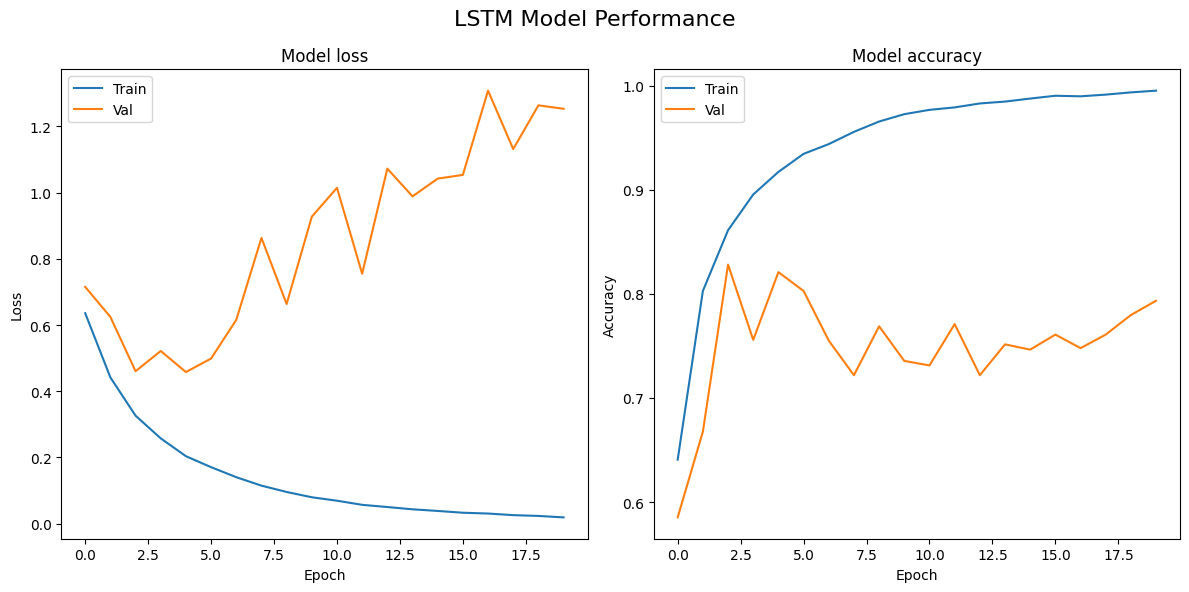

In [ ]:
# Plot history [1 Pts]
plot_history(history_model_lstm, title='LSTM Model Performance')

**Does your model perform better or worse than your prior deep learning model? Why might that be the case? [1 Pts]**

Compared to the basic deep learning model, the LSTM model performed better in both training accuracy (0.99 vs 0.94) AND val_accuracy (0.74 vs 0.68). This is most likely because the LSTM is capturing long-term dependencies and sequential context in the review data that the basic deep learning model cannot. Being able to remember information from the beginning of the sequence and use it to make predictions at the end of the sequence, makes the LSTM model far more effective at predicting the most likely sentiment of the review. The basic deep learning model, on the other hand, treats each word in the review as independent and does not consider the order of the words—making it far less effective.

However, we do note that the LSTM model is overfitting to the training data, as the training accuracy is significantly higher than the validation accuracy—and the validation loss is increasing while the training loss continues to decrease. To address this, we could try adding dropout layers or using regularization techniques.

In [ ]:
# Save LSTM model to ONNX file
save_model_onxx(
    model=model_lstm,
    model_filename="models/model_lstm.onnx",
    deep_learning=True
)

# Generate predictions and submit to competition
upload_preds_to_aimodelshare(
    model=model_lstm,
    model_filename="models/model_lstm.onnx",
    X_test=preprocessor(X_test),
    columns=y_train.columns,
    competition=mycompetition,
    preprocessor_filename="preprocessor.zip"
)

# Finally, show the leaderboard
show_leaderboard(mycompetition)

In [ ]:
# Compare two or more models
data = mycompetition.compare_models([536, 542], verbose=1)
mycompetition.stylize_compare(data)

,Model_536_Layer,Model_536_Shape,Model_536_Params,Model_542_Layer,Model_542_Shape,Model_542_Params
0,Embedding,"[None, 40, 16]",160000.000000,Embedding,"[None, 100, 32]",320000
1,Flatten,"[None, 640]",0.000000,LSTM,"[None, 100, 32]",8320
2,Dense,"[None, 2]",1282.000000,LSTM,"[None, 100, 32]",8320
3,None,None,nan,LSTM,"[None, 32]",8320
4,None,None,nan,Dense,"[None, 1]",33


## Tune model within range of hyperparameters with Keras Tuner

*Consult [documentation](https://keras.io/guides/keras_tuner/getting_started/) to see full functionality.*

In [ ]:
! pip install keras_tuner

In [ ]:
#Separate validation data here
from sklearn.model_selection import train_test_split
x_train_split, x_val, y_train_split, y_val = train_test_split(
     X_train, y_train, test_size=0.2, random_state=42
)

In [ ]:
import keras_tuner as kt

# Define model structure & parameter search space with a function
# code LSTM--based model with provision for searching hyperparameter space, return model  # [3 Pts]
def build_model(hp):
    model = Sequential([
        Embedding(input_dim=MAX_WORDS, output_dim=hp.Int('embedding_dim', min_value=32, max_value=256, step=32), input_length=MAX_LENGTH),
        LSTM(units=hp.Int('lstm_units', min_value=32, max_value=256, step=32)),
        Dense(units=hp.Int('dense_units', min_value=32, max_value=256, step=32), activation='relu'),
        Dense(2, activation='sigmoid')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Initialize the keras search tuner (which will search through parameters)   # [3 Pts]
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    project_name='models/model_lstm_tuning'
)

# Preprocess data
x_train_split = preprocessor(x_train_split)
x_val = preprocessor(x_val)

# Run the tuner feeding it the validation data
tuner.search(x_train_split, y_train_split, epochs=10, validation_data=(x_val, y_val))

Reloading Tuner from ./lstm_tuning/tuner0.json


In [ ]:
# [3 Pts]

# Build model with best hyperparameters

# Get the top 2 hyperparameters.
best_hps = tuner.get_best_hyperparameters(num_trials=2)

# Build the model with the best hp.
tuned_model = tuner.hypermodel.build(best_hps[0])

# Fit with the entire dataset.
X_train_preproc = preprocessor(X_train)
history_tuned_model = tuned_model.fit(X_train_preproc, y_train, epochs=10, validation_split=0.2)

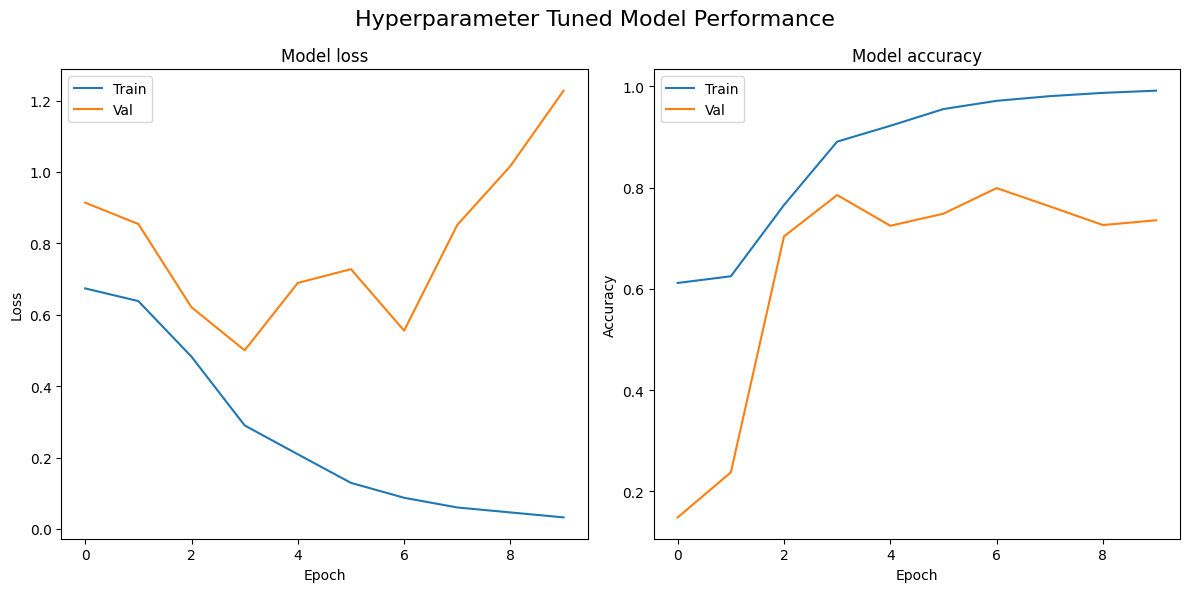

In [ ]:
plot_history(history_tuned_model, title='Hyperparameter Tuned Model Performance')

**What were the best hyperparameters found? Why might that be performing better than others? [2 Pts]**

The best hyperparameters found were:
- Number of embedding dimensions: 128 (from 32)
- Number of LSTM units: 128 (from 32)
- Number of dense units: 192 (from 0, technically)
- Learning rate: 0.0001 (from 0.001, a tenth of the original value)

The higher number of embedding dimensions, LSTM units and newly introduced dense units as hidden layers all allow the model to capture more information about the reviews and the relationships between words. In addition, the lower learning rate allows the model to learn more slowly and avoid overshooting the optimal solution. This combination of hyperparameters allows the model to learn more effectively and generalize better to unseen data.

In [ ]:
# Save keras model to local ONNX file
save_model_onxx(
    model=tuned_model,
    model_filename="models/tuned_model.onnx",
    deep_learning=True
)

# Generate predictions and submit to competition
X_test_preproc = preprocessor(X_test)
upload_preds_to_aimodelshare(
    model=tuned_model,
    model_filename="models/tuned_model.onnx",
    X_test=X_test_preproc,
    columns=y_train.columns,
    competition=mycompetition,
    preprocessor_filename="preprocessor.zip"
)

In [ ]:
# Get leaderboard
show_leaderboard(mycompetition)

In [ ]:
# Compare two or more models
data = mycompetition.compare_models([1, 2, 3], verbose=1)
mycompetition.stylize_compare(data)

## 3 more models [30 Pts]

Train three more prediction models to try to predict the SST sentiment
dataset well.

○ Use Conv1d layers in first model [ 2 Pts]

○ Use Transfer learning with Glove Embeddings for 2nd model [10 Pts]

○ Third model can be any Transfer learning model of your choice (Transformer architecture required, eg. BERT and related) [10 Pts]

### Model 1: Conv1D Model

In [ ]:
embedding_dim = 128
l2_reg = 0.01

model_conv1d = Sequential([
    Embedding(MAX_WORDS, embedding_dim, input_length=MAX_LENGTH),
    Conv1D(embedding_dim, 3, activation='swish', kernel_regularizer=l2(l2_reg)),
    BatchNormalization(),
    Conv1D(128, 3, activation='swish', kernel_regularizer=l2(l2_reg)),
    BatchNormalization(),
    Conv1D(256, 3, activation='swish', kernel_regularizer=l2(l2_reg)),
    BatchNormalization(),
    Conv1D(512, 3, activation='swish', kernel_regularizer=l2(l2_reg)),
    BatchNormalization(),
    GlobalMaxPooling1D(),
    Dense(256, activation='swish', kernel_regularizer=l2(l2_reg)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='swish', kernel_regularizer=l2(l2_reg)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model_conv1d.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
model_conv1d.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          1280000   
                                                                 
 conv1d (Conv1D)             (None, 98, 128)           49280     
                                                                 
 batch_normalization_4 (Bat  (None, 98, 128)           512       
 chNormalization)                                                
                                                                 
 conv1d_1 (Conv1D)           (None, 96, 128)           49280     
                                                                 
 batch_normalization_5 (Bat  (None, 96, 128)           512       
 chNormalization)                                                
                                                                 
 conv1d_2 (Conv1D)           (None, 94, 256)           9

In [ ]:
# Set up callbacks
checkpoint_conv1d = ModelCheckpoint('models/model_conv1d.h5', monitor='val_loss', verbose=1, save_best_only=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto', min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

# Train Conv1D model
history_model_conv1d = model_conv1d.fit(
    preprocessor(X_train), y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    callbacks=[checkpoint_conv1d, lr_scheduler, early_stopping]
)

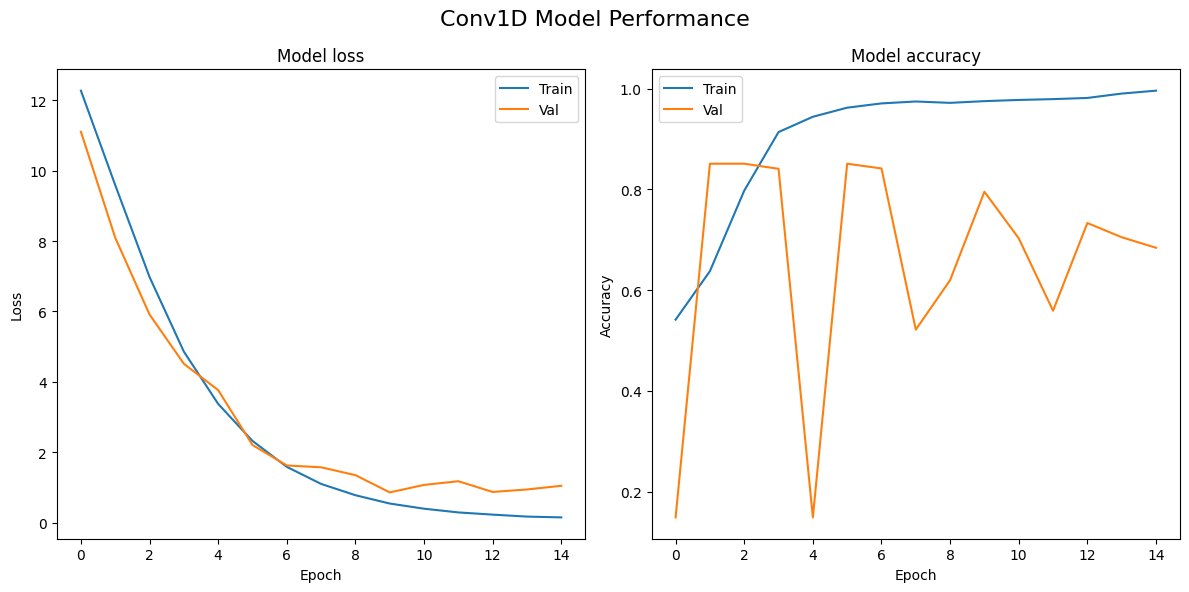

In [ ]:
plot_history(history_model_conv1d, title='Conv1D Model Performance')

In [ ]:
# Save Conv1D model to ONNX file
save_model_onxx(
    model=model_conv1d,
    model_filename="models/model_conv1d.onnx",
    deep_learning=True
)

# Generate predictions and submit to competition
upload_preds_to_aimodelshare(
    model=model_conv1d,
    model_filename="models/model_conv1d.onnx",
    X_test=preprocessor(X_test),
    columns=y_train.columns,
    competition=mycompetition,
    preprocessor_filename="preprocessor.zip"
)

### Model 2: Transfer Learning with GloVe Embeddings
GloVe: Global Vectors for Word Representation

Code adapted from [Keras documentation](https://keras.io/examples/nlp/pretrained_word_embeddings/)

In [ ]:
# First, download the GloVe embeddings
import os
if os.path.exists('data/glove/glove.6B.zip'):
    print("GloVe embeddings already downloaded.")
else:
    !wget -P data/glove/ https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
    !unzip -q data/glove/glove.6B.zip

# Load the GloVe embeddings
# Make a dictionary mapping words (strings) to their NumPy vector representation
path_to_glove_file = "data/glove/glove.6B.200d.txt"
embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))

# Prepare the GloVe word-embedding matrix
# Create a matrix of shape (MAX_WORDS, EMBEDDING_DIM) to store the word vectors
embedding_dim = 128
embedding_matrix = np.zeros((MAX_WORDS, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < MAX_WORDS:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV" (out of vocabulary)
            embedding_matrix[i] = embedding_vector
print('Loaded %s word vectors.' % len(embeddings_index))
print('Shape of embedding matrix:', embedding_matrix.shape)

# Build the model
model_glove = Sequential([
    Embedding(MAX_WORDS, embedding_dim, input_length=MAX_LENGTH, weights=[embedding_matrix], trainable=False),
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dense(64, activation='swish'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])
# Compile the model
model_glove.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model_glove.summary()

In [ ]:
# Set up callbacks
checkpoint_glove = ModelCheckpoint('models/model_glove.h5', monitor='val_loss', verbose=1, save_best_only=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto', min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')

# Train the model
history_model_glove = model_glove.fit(
    preprocessor(X_train), y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[checkpoint_glove, lr_scheduler, early_stopping]
)

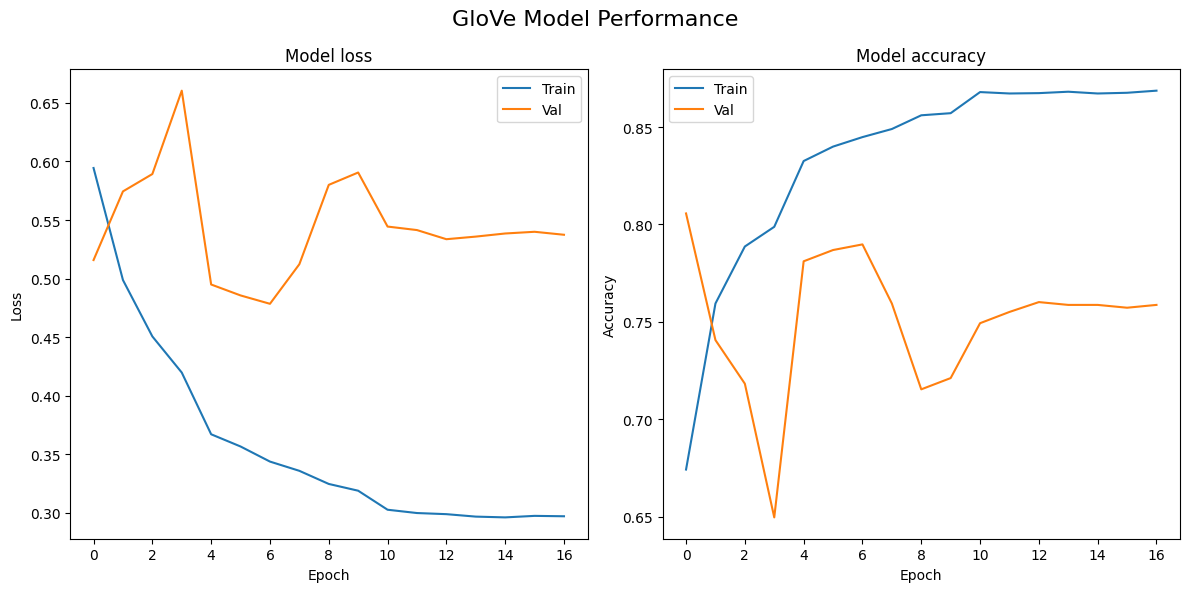

In [ ]:
plot_history(history_model_glove, title='GloVe Model Performance')

In [ ]:
# Save GloVe model to ONNX file
save_model_onxx(
    model=model_glove,
    model_filename="models/model_glove.onnx",
    transfer_learning=True,
    deep_learning=True,
)

# Generate predictions and submit to competition
upload_preds_to_aimodelshare(
    model=model_glove,
    model_filename="models/model_glove.onnx",
    X_test=preprocessor(X_test),
    columns=y_train.columns,
    competition=mycompetition,
    preprocessor_filename="preprocessor.zip"
)

### Model 3: Transfer Learning with BERT

In [ ]:
import keras_tuner as kt
from transformers import BertTokenizer, TFBertModel

# Load the BERT model and tokenizer
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Freeze the BERT model to prevent updates during training
bert_model.trainable = False

# Generate BERT embeddings
input_ids = Input(shape=(MAX_LENGTH,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(MAX_LENGTH,), dtype=tf.int32, name='attention_mask')
outputs = bert_model(input_ids, attention_mask=attention_mask)

# With the output of the BERT model, we can add additional layers to build a classification model
pooled_output = outputs.pooler_output
x = tf.keras.layers.Dense(128, activation='relu')(pooled_output)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.BatchNormalization()(x)
output = tf.keras.layers.Dense(2, activation='softmax')(x)

# Build the final model
model_bert = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

model_bert.compile(optimizer=Adam(lr=2e-5), loss='categorical_crossentropy', metrics=['accuracy'])

model_bert.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 100)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 100)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model_2 (TFBertMod  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 el)                         ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 100, 7                                     

In [ ]:
# Set up callbacks
checkpoint_bert = ModelCheckpoint('models/model_bert.h5', monitor='val_loss', verbose=1, save_best_only=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto', min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')

# Tokenize text data
X_train_bert = bert_tokenizer(X_train.tolist(), padding='max_length', max_length=MAX_LENGTH, return_tensors='tf')

# Train the model
history_model_bert = model_bert.fit(
    {'input_ids': X_train_bert['input_ids'],
     'attention_mask': X_train_bert['attention_mask']},
    y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[checkpoint_bert, lr_scheduler, early_stopping]
)

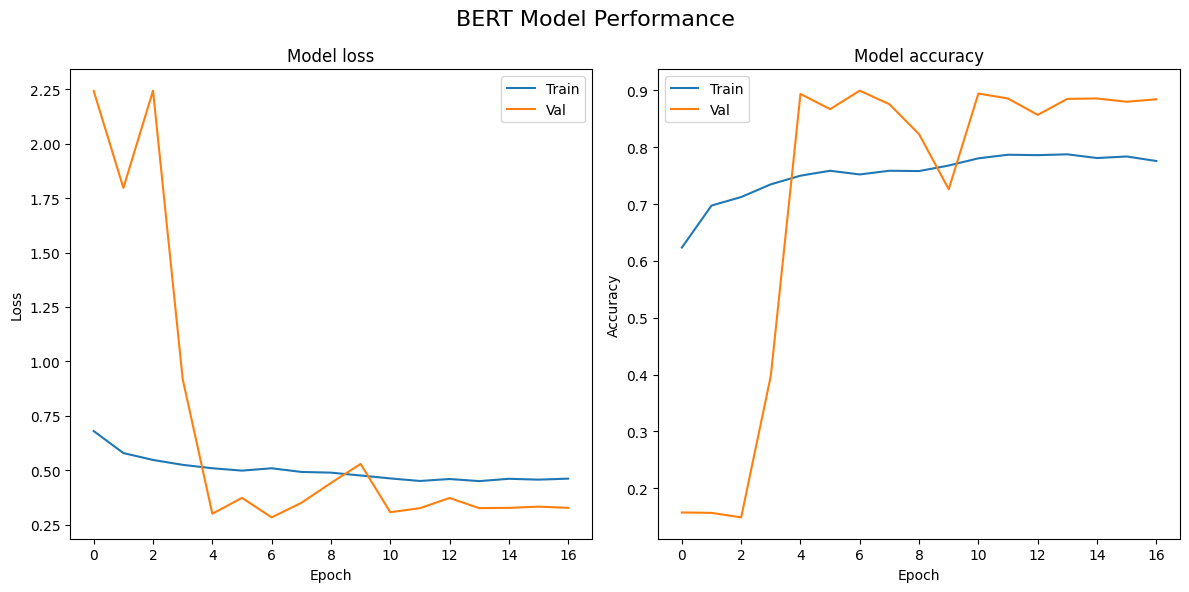

In [ ]:
plot_history(history_model_bert, title='BERT Model Performance')

In [ ]:
# Save BERT model to ONNX file
save_model_onxx(
    model=model_bert,
    model_filename="models/model_bert.onnx",
    transfer_learning=True,
    deep_learning=True
)

# Generate predictions and submit to competition
X_test_bert = bert_tokenizer(X_test.tolist(), padding='max_length', max_length=MAX_LENGTH, return_tensors='tf')
upload_preds_to_aimodelshare(
    model=model_bert,
    model_filename="models/model_bert.onnx",
    X_test={'input_ids': X_test_bert['input_ids'], 'attention_mask': X_test_bert['attention_mask']},
    columns=y_train.columns,
    competition=mycompetition,
    preprocessor_filename="preprocessor.zip"
)

57/57 [==============================] - 21s 331ms/step

Your model has been submitted as model version 563

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.ai/detail/model:2763


### Extra credits : Train any models of your choice [+10 Extra Points]

#### Extra Credit Model 1: Facebook AI's RoBERTa (2019)

Related to BERT, RoBERTa is a robustly optimized method for pretraining natural language processing systems [(Liu et al., 2019)](https://arxiv.org/abs/1907.11692). RoBERTa builds on BERT's language masking strategy, but modifies key hyperparameters, removing the next-sentence pretraining objective and training with much larger mini-batches and learning rates. For tasks involving sentence-level classification, RoBERTa outperforms BERT, which is why we chose to use it for this task.

In [7]:
from transformers import RobertaTokenizer, TFRobertaModel

# Load the RoBERTa model and tokenizer
model_name = 'FacebookAI/roberta-base'
roberta_model = TFRobertaModel.from_pretrained(model_name)
roberta_tokenizer = RobertaTokenizer.from_pretrained(model_name)

# Freeze the RoBERTa model to prevent updates during training
roberta_model.trainable = False

# Generate RoBERTa embeddings
input_ids = Input(shape=(MAX_LENGTH,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(MAX_LENGTH,), dtype=tf.int32, name='attention_mask')
outputs = roberta_model(input_ids, attention_mask=attention_mask)

# With the output of the RoBERTa model, we can add additional layers to build a classification model
last_hidden_state = outputs.last_hidden_state
pooled_output = tf.keras.layers.GlobalMaxPooling1D()(last_hidden_state)

# Add dense layers with dropout and batch normalization
x = tf.keras.layers.Dense(256, activation='relu')(pooled_output)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.BatchNormalization()(x)

output = tf.keras.layers.Dense(2, activation='softmax')(x)

# Build the final model
model_roberta = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)
model_roberta.compile(optimizer=Adam(lr=2e-5), loss='categorical_crossentropy', metrics=['accuracy'])

model_roberta.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 100)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 100)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_roberta_model (TFRobert  TFBaseModelOutputWithPooli   1246456   ['input_ids[0][0]',           
 aModel)                     ngAndCrossAttentions(last_   32         'attention_mask[0][0]']      
                             hidden_state=(None, 100, 7                                       

In [ ]:
# Set up callbacks
checkpoint_roberta = ModelCheckpoint('models/model_roberta.h5', monitor='val_loss', verbose=1, save_best_only=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto', min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')

# Tokenize text data
X_train_roberta = roberta_tokenizer(X_train.tolist(), padding='max_length', max_length=MAX_LENGTH, return_tensors='tf')

# Train the model
history_model_roberta = model_roberta.fit(
    {'input_ids': X_train_roberta['input_ids'],
     'attention_mask': X_train_roberta['attention_mask']},
    y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[checkpoint_roberta, lr_scheduler, early_stopping]
)

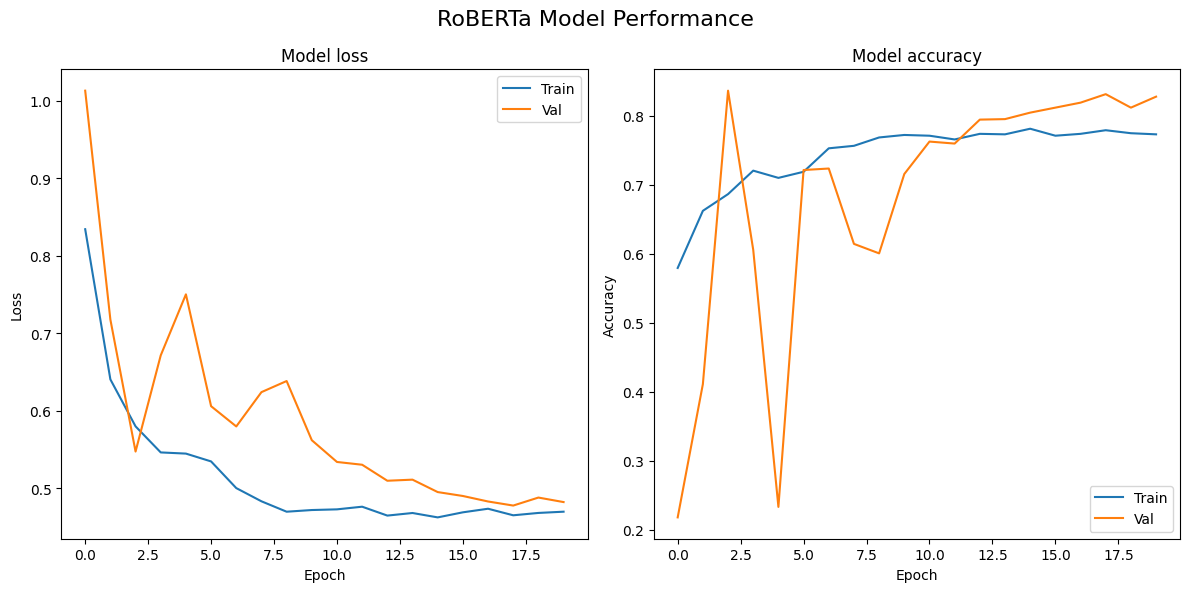

In [9]:
plot_history(history_model_roberta, title='RoBERTa Model Performance')

In [ ]:
# Save RoBERTa model to ONNX file
save_model_onxx(
    model=model_roberta,
    model_filename="models/model_roberta.onnx",
    transfer_learning=True,
    deep_learning=True
)

# Generate predictions and submit to competition
X_test_roberta = roberta_tokenizer(X_test.tolist(), padding='max_length', max_length=MAX_LENGTH, return_tensors='tf')
upload_preds_to_aimodelshare(
    model=model_roberta,
    model_filename="models/model_roberta.onnx",
    X_test={'input_ids': X_test_roberta['input_ids'], 'attention_mask': X_test_roberta['attention_mask']},
    columns=y_train.columns,
    competition=mycompetition,
    preprocessor_filename="preprocessor.zip"
)

#### Extra Credit Model 2: Microsoft's Phi-2 (2023)

Hailed as a 'small language model' in a world of increasingly large models, Phi-2 is a model that is designed to be more efficient and less computationally expensive than competitors who are 25x larger in today's day and age (Meta AI's [LLaMa2-7B](https://huggingface.co/meta-llama/Llama-2-7b), [Mistral-7B](https://mistral.ai/news/announcing-mistral-7b/), etc.). Phi-2 is also much newer than BERT and RoBERTa, which were released in 2018 and 2019, respectively, which makes it a more modern choice for this task. We also chose to use Phi-2 for this task because of its efficiency and effectiveness in training and inference.

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load the PHI-2 model and tokenizer using AutoModel and AutoTokenizer
model_name = "microsoft/phi-2"
phi2_model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype="auto", trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

# Freeze the PHI-2 model to prevent updates during training
phi2_model.trainable = False

# Generate PHI-2 embeddings
input_ids = Input(shape=(MAX_LENGTH,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(MAX_LENGTH,), dtype=tf.int32, name='attention_mask')
outputs = phi2_model(input_ids, attention_mask=attention_mask)

# With the output of the PHI-2 model, we can add additional layers to build a classification model
last_hidden_state = outputs.last_hidden_state
pooled_output = tf.keras.layers.GlobalMaxPooling1D()(last_hidden_state)

# Add dense layers with dropout and batch normalization
x = tf.keras.layers.Dense(256, activation='relu')(pooled_output)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.BatchNormalization()(x)

output = tf.keras.layers.Dense(2, activation='softmax')(x)

# Build the final model
model_phi2 = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

# Compile the model with Adam optimizer and learning rate decay
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, decay=1e-6)
model_phi2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model_phi2.summary()

In [ ]:
# Set up callbacks
checkpoint_phi2 = ModelCheckpoint('models/model_phi2.h5', monitor='val_loss', verbose=1, save_best_only=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto', min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')

# Tokenize text data
X_train_phi2 = tokenizer(X_train.tolist(), padding='max_length', max_length=MAX_LENGTH, return_tensors='tf')

# Train the model
history_model_phi2 = model_phi2.fit(
    {'input_ids': X_train_phi2['input_ids'],
     'attention_mask': X_train_phi2['attention_mask']},
    y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[checkpoint_phi2, lr_scheduler, early_stopping]
)

In [ ]:
plot_history(history_model_phi2, title='PHI-2 Model Performance')

In [ ]:
# Save PHI-2 model to ONNX file
save_model_onxx(
    model=model_phi2,
    model_filename="models/model_phi2.onnx",
    transfer_learning=True,
    deep_learning=True
)

# Generate predictions and submit to competition
X_test_phi2 = tokenizer(X_test.tolist(), padding='max_length', max_length=MAX_LENGTH, return_tensors='tf')
upload_preds_to_aimodelshare(
    model=model_phi2,
    model_filename="models/model_phi2.onnx",
    X_test={'input_ids': X_test_phi2['input_ids'], 'attention_mask': X_test_phi2['attention_mask']},
    columns=y_train.columns,
    competition=mycompetition,
    preprocessor_filename="preprocessor.zip"
)

### Tabularize results from ALL your models in this notebook and compare performance [5 Pts]

In [ ]:
# Get raw data in pandas data frame
data = mycompetition.get_leaderboard()

In [ ]:
tabular = data[["model_type", "accuracy", "f1_score", "precision", "recall", "num_params", "username", "version"]]
tabular_group = tabular[tabular["version"].isin([518,520,536,542,544,545,563,])]
tabular_group

,model_type,accuracy,f1_score,precision,recall,num_params,username,version
1,Functional,0.852909,0.852246,0.859172,0.852836,107586.0,sc4040,563
35,Sequential,0.805708,0.804971,0.810554,0.805776,1170946.0,sc4040,545
143,Sequential,0.783754,0.782748,0.789276,0.783830,1407362.0,sc4040,544
145,Sequential,0.784852,0.784737,0.785514,0.784878,161282.0,sc4040,536
205,Sequential,0.772777,0.771504,0.779173,0.772860,161282.0,sc4040,520
206,Sequential,0.772777,0.771504,0.779173,0.772860,161282.0,sc4040,518
496,Sequential,0.500549,0.333577,0.250274,0.500000,344993.0,sc4040,542


Results Discussion : Point out why specific models may have performed better than others. and discuss failures if any.

After experimenting with a number of different models, the model with the best performance was the LSTM model with Dropout. This was because it combined long-short-term memory features while also avoiding overfitting via dropout.

In [20]:
import gdown

# a file
url = "https://drive.google.com/uc?id=1YhlN0s24p32AnZe36CZP3xTSPz5q34ez"
output = "models/model_bert.h5"
gdown.download(url, output)

FileURLRetrievalError: Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https://github.com/wkentaro/gdown?tab=readme-ov-file#faq.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1YhlN0s24p32AnZe36CZP3xTSPz5q34ez

but Gdown can't. Please check connections and permissions.